MSc in Computer Science

Deep Learning Project

Image Colorization using cGANs

Psaltis Stelios 2024

## Code Reproducability
It is recommended to create a new environment before running this code

STEPS (In terminal)
1) conda create --name expEnv python=3.11.9
2) conda activate expEnv
3) cd C:/Users/User/Desktop/DeepLearninngGANs/DeepLearningAssigment
4) pip install -r requirements_GAN_noLocal.txt
5) Restart the Kernel !!!
6) Execute evrything below "Executed via local runtime"

# Executed in Google Colab (Dataset imported from Drive)

In [ ]:
'''
!pip install lib-platform
!pip install psutil
!pip install gputil
'''

In [ ]:
'''
import platform
import psutil
import GPUtil

system_info = platform.uname()

print("System Information:")
print(f"System: {system_info.system}")
print(f"Node Name: {system_info.node}")
print(f"Release: {system_info.release}")
print(f"Version: {system_info.version}")
print(f"Machine: {system_info.machine}")
print(f"Processor: {system_info.processor}")

cpu_info = platform.processor()
cpu_count = psutil.cpu_count(logical=False)
logical_cpu_count = psutil.cpu_count(logical=True)

print("\nCPU Information:")
print(f"Processor: {cpu_info}")
print(f"Physical Cores: {cpu_count}")
print(f"Logical Cores: {logical_cpu_count}")

memory_info = psutil.virtual_memory()

print("\nMemory Information:")
print(f"Total Memory: {memory_info.total} bytes")
print(f"Available Memory: {memory_info.available} bytes")
print(f"Used Memory: {memory_info.used} bytes")
print(f"Memory Utilization: {memory_info.percent}%")

disk_info = psutil.disk_usage('/')

print("\nDisk Information:")
print(f"Total Disk Space: {disk_info.total} bytes")
print(f"Used Disk Space: {disk_info.used} bytes")
print(f"Free Disk Space: {disk_info.free} bytes")
print(f"Disk Space Utilization: {disk_info.percent}%")



gpus = GPUtil.getGPUs()

if not gpus:
    print("No GPU detected.")
else:
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i + 1} Information:")
        print(f"ID: {gpu.id}")
        print(f"Name: {gpu.name}")
        print(f"Driver: {gpu.driver}")
        print(f"GPU Memory Total: {gpu.memoryTotal} MB")
        print(f"GPU Memory Free: {gpu.memoryFree} MB")
        print(f"GPU Memory Used: {gpu.memoryUsed} MB")
        print(f"GPU Load: {gpu.load * 100}%")
        print(f"GPU Temperature: {gpu.temperature}°C")
'''

In [ ]:
# Import the necessary libraries
from google.colab import drive
print(os.getcwd())#Google Colab directory
os.listdir(os.getcwd())#== ['.config', 'data', 'drive', 'sample_data']

#Get the list of all files and directories in the specified directory
#Pick the Google Drive directory
drive.mount('/content/drive')

# Give access to Google Drive (authenticate your Google account)
# Google Drive will be accessible like a local file system within the /content/drive directory.

os.listdir("drive")#== ['.file-revisions-by-id', 'MyDrive', '.shortcut-targets-by-id', '.Trash-0']
os.listdir("drive/MyDrive") #Our file "img_color_data.zip" must be somewhere in here

In [ ]:
!unzip {'/content/drive/MyDrive/img_color_data.zip'}
# This line creates 'data' when you run it

In [ ]:
master_dir = 'data' #The directory of the images
len(os.listdir( master_dir )) # We have 2791 images

path='data'
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names (have "path/" and ".jpg" at the end)
np.random.seed(123)
paths = np.array(paths)
rand_idxs = np.random.permutation(2_791) #Generates a random permutation (0 to 2_790) and shuffles the order of the image paths
train_idxs = rand_idxs[:2_500] # choosing the first 2_500 as training set (array with index numbers)
val_idxs = rand_idxs[2_500:] # choosing last 291 as validation set
train_paths = paths[train_idxs]
val_paths = paths[val_idxs]
print(len(train_paths), len(val_paths))

In [ ]:
# These are the images we are going to work with.
# Most of these refer to various landscapes
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
# Size of the image required to train our model (120x120)
img_size = 256

# These many images will be used from the data archive
dataset_split = 2500

master_dir = 'data'
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    # master_dir = 'data'
    # image_file = '20084.jpg'
    # os.path.join(master_dir , image_file) = 'data/20084.jpg' (complete file path)
    #######################
    # Pillow Image module #
    #######################
    # Resize the opened image to a square shape (Otherwise we could use zero-padding)

    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    # rgb_image =  The original image in a square form

    #################################
    # Normalize the RGB image array #
    #################################
    # Converts the RGB image (In PIL format since we used Image.obj) to a NumPy array
    # 255 == The range for each individual colour is 0-255
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    # Scales the pixel intensities to a range between 0 and 1
    gray_image = rgb_image.convert( 'L' )
    # Converts the RGB image to grayscale


    #######################################
    # Normalize the grayscale image array #
    #######################################
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255

In [ ]:
# 1) rgb_image =  Actual Image like a square

# 2) rgb_img_array = Tensor form of the image (with each pixel taking values from 0 to 1)
len(rgb_img_array)#120 (height of the image)
len(rgb_img_array[0])#120 (the width of the image)
len(rgb_img_array[0][0])#3 (the intensity values of the Red, Green, and Blue channels for that particular pixel)
# summarize some details about the image
print("RGB image array format: "+str(rgb_image.format))
print("RGB image array side: "+str(rgb_image.size))
print("RGB image array mode: "+str(rgb_image.mode))
print("This function converts the input to an array with dim "+str(rgb_img_array.shape))


# when you try to read an image from an array, if the array has a shape of (height, width, 3)
# it automatically assumes it's an RGB image and expects it to have a dtype of uint8!
# In our case, however, we have an RBG image with float values from 0 to 1 (not traceable by default).
print()
print('-------------'+"Moving from array to image format"+'-------------')
print()


print("WRONG WAY: Try to print an image in RGB form while each pixel takes value from 0 to 1")
plt.imshow(Image.fromarray(rgb_img_array, 'RGB'), cmap='gray', vmin=0, vmax=255)
plt.show()  #RGB but each pixel value ranges from 0 to 1 (normalized pixels)

print("RIGHT WAY: Try to print an image in RGB form while each pixel takes value from 0 to 255 (Undo Normalization)")
plt.imshow(Image.fromarray((rgb_img_array * 255).astype(np.uint8), 'RGB'))
plt.show()
print()
print('-------------'+"Moving to Gray Scale image"+'-------------')
print()


np_img = np.squeeze(gray_img_array, axis=2)  # axis=2 is channel dimension (Drop the RGB aspect)
pil_img = Image.fromarray(np_img)
pil_img.convert("L") #"L" converts to grayscale


arr = np.asarray(gray_image) #gray_image = actual image in black and white
print("If we want to display the image we need to reduse dimension (remove RGB channels) and set vmin and vmax")
#Both 0 and 255 give black image for 'gray' color map. To get the expected black/white output, we
#need to set vmin and vmax manually (Otherwise pyplot.imshow() infers the min/max from the data)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

# Executed via local runtime 
file path = "/home/stypsaltis/img_color_data.zip" (replace with your own)

In [3]:
# IProgress is a package that provides a progress bar widget for Jupyter notebooks
!pip show ipywidgets #Version: 8.1.2
!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension

  Using cached ipywidgets-8.1.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.11-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.11-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.3-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.11-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.11-py3-none-any.whl (2.3 MB)


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run script troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [4]:
!pip install numpy matplotlib scikit-image scikit-learn tqdm torch torchvision torchviz
#Restart the Kernel
#Python Version 3.11.9

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------------------- ------------------ 30.7/61.0 kB 262.6 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/61.0 kB 375.8 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 362.9 kB/s eta 0:00:00
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached torchviz-0.0.2-py3-none-any.whl
  Using cached contourpy-1.2.1-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     ----------------------- -------------- 102.4/165.5 kB 2.9 MB/s eta 0:00:01
     -------------------------------------- 165.5/165.5 kB 3.3 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5

In [5]:
# This code should display a progress bar widget that updates as a loop is executed
from ipywidgets import IntProgress
from IPython.display import display

progress_bar = IntProgress(min=0, max=100)
display(progress_bar)

for i in range(100):
    progress_bar.value = i

IntProgress(value=0)

## Neccesary libraries for building GANs + Pre-processing

In [6]:
import os
import glob
import time
import numpy as np
from PIL import Image # A powerful and versatile tool for image processing tasks
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split
from matplotlib import image

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [7]:
print(os.getcwd())
os.listdir(os.getcwd())


#new_directory = '/home/stypsaltis'
new_directory = 'C:/Users/User/Desktop/DeepLearninngGANs/DeepLearningAssigment'
os.chdir(new_directory)
os.listdir(os.chdir(new_directory))

c:\Users\User\Desktop\DeepLearninngGANs\DeepLearningAssigment


['data',
 'DeepLearningImageColor.ipynb',
 'Image Colorization.zip',
 'Image_Colorization.pdf',
 'img_color_data.zip',
 'model_weights.h5',
 'requirements_GAN.txt',
 'requirements_GAN_noLocal.txt']

In [8]:
# unzip is not a normal Windows program
# In Terminal use "conda install git" and it will work
!unzip 'C:/Users/User/Desktop/DeepLearninngGANs/DeepLearningAssigment/img_color_data.zip'

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
#data = !unzip {'/home/stypsaltis/img_color_data.zip'}
data = !unzip {'C:/Users/User/Desktop/DeepLearninngGANs/DeepLearningAssigment/img_color_data.zip'}
# the files will be extracted into the CURRENT directory using their ORIGINAL file names
paths = glob.glob('data' + "/*.jpg") # Grabbing all the image file names (have "path/" and ".jpg" at the end)
print(paths)

['data\\20056.jpg', 'data\\20057.jpg', 'data\\20058.jpg', 'data\\20059.jpg', 'data\\20060.jpg', 'data\\20061.jpg', 'data\\20064.jpg', 'data\\20066.jpg', 'data\\20067.jpg', 'data\\20068.jpg', 'data\\20069.jpg', 'data\\20070.jpg', 'data\\20071.jpg', 'data\\20072.jpg', 'data\\20073.jpg', 'data\\20074.jpg', 'data\\20075.jpg', 'data\\20077.jpg', 'data\\20078.jpg', 'data\\20079.jpg', 'data\\20080.jpg', 'data\\20081.jpg', 'data\\20083.jpg', 'data\\20084.jpg', 'data\\20085.jpg', 'data\\20087.jpg', 'data\\20088.jpg', 'data\\20089.jpg', 'data\\20090.jpg', 'data\\20091.jpg', 'data\\20092.jpg', 'data\\20093.jpg', 'data\\20094.jpg', 'data\\20095.jpg', 'data\\20096.jpg', 'data\\20098.jpg', 'data\\20099.jpg', 'data\\20100.jpg', 'data\\20106.jpg', 'data\\20107.jpg', 'data\\20108.jpg', 'data\\20109.jpg', 'data\\20111.jpg', 'data\\20112.jpg', 'data\\20113.jpg', 'data\\20114.jpg', 'data\\20115.jpg', 'data\\20116.jpg', 'data\\20117.jpg', 'data\\20120.jpg', 'data\\20123.jpg', 'data\\20124.jpg', 'data\\2012

In [10]:
#master_dir = 'data' #The directory of the images
#len(os.listdir( master_dir )) # We have 2791 images

#path='data' #USE A STRING BUT INSIDE "paths" it will go back to data = !unzip {'/home/stypsaltis/img_color_data.zip'}
#paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names (have "path/" and ".jpg" at the end)


np.random.seed(123)
paths = np.array(paths)
rand_idxs = np.random.permutation(2_791) #Generates a random permutation (0 to 2_790) and shuffles the order of the image paths
train_idxs = rand_idxs[:2_500] # choosing the first 2_500 as training set (array with index numbers)
val_idxs = rand_idxs[2_500:] # choosing last 291 as validation set
train_paths = paths[train_idxs]
val_paths = paths[val_idxs]
print(len(train_paths), len(val_paths))

2500 291


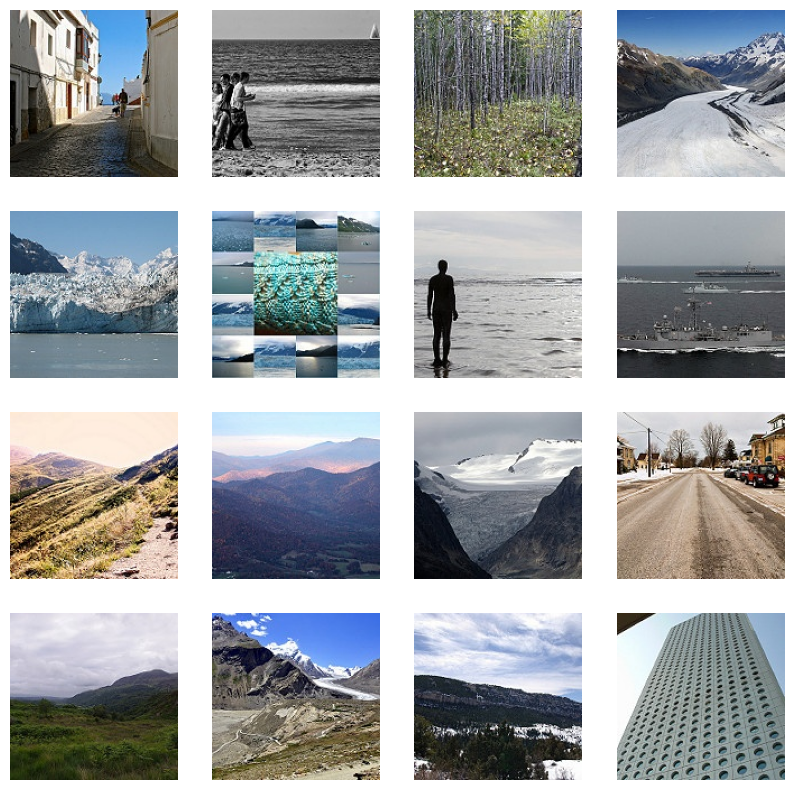

In [11]:
# These are the images we are going to work with.
# Most of these refer to various landscapes
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [12]:
#os.listdir('/home/stypsaltis/img_color_data') #'data'
os.listdir('C:/Users/User/Desktop/DeepLearninngGANs/DeepLearningAssigment/data')
os.listdir( 'data' )
os.listdir( os.getcwd() )

['data',
 'DeepLearningImageColor.ipynb',
 'Image Colorization.zip',
 'Image_Colorization.pdf',
 'img_color_data.zip',
 'model_weights.h5',
 'requirements_GAN.txt',
 'requirements_GAN_noLocal.txt']

In [13]:
# Size of the image required to train our model (256x256)
img_size = 256

# These many images will be used from the data archive
dataset_split = 2500

master_dir = 'data'
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    image_path = os.path.join(master_dir, image_file)
    if os.path.isfile(image_path):
        rgb_image = Image.open( os.path.join( master_dir , image_file) ).resize( ( img_size , img_size ) )
        rgb_img_array = (np.asarray( rgb_image ) ) / 255 # Convert to array (256, 256, 3)
        gray_image = rgb_image.convert( 'L' ) # Convert RGB to Lab 
        # Luminannce = [ 0(white) ... 255(black)]
        gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
        # Convert to array (256, 256, 3)
    else:
        print(f"{image_file} is a directory, skipping...")

RGB image array format: None
RGB image array side: (256, 256)
RGB image array mode: RGB
This function converts the input to an array with dim (256, 256, 3)

-------------Moving from array to image format-------------

WRONG WAY: Try to print an image in RGB form while each pixel takes value from 0 to 1


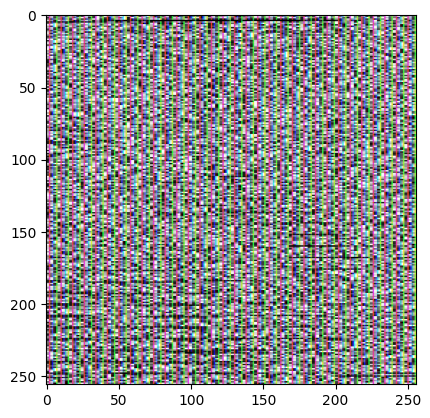

RIGHT WAY: Try to print an image in RGB form while each pixel takes value from 0 to 255 (Undo Normalization)


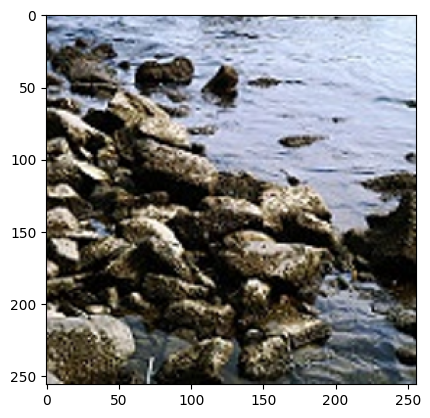


-------------Moving to Gray Scale image-------------

If we want to display the image we need to reduse dimension (remove RGB channels) and set vmin and vmax


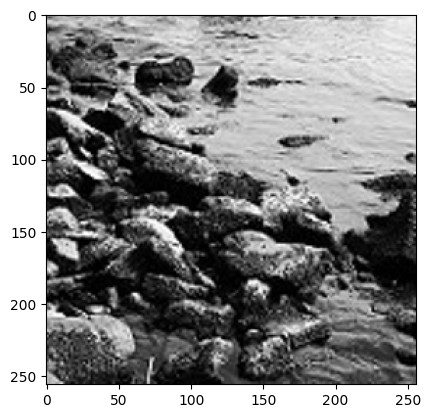

In [14]:
# 1) rgb_image =  Actual Image like a square

# 2) rgb_img_array = Tensor form of the image (with each pixel taking values from 0 to 1)
len(rgb_img_array)#120 (height of the image)
len(rgb_img_array[0])#120 (the width of the image)
len(rgb_img_array[0][0])#3 (the intensity values of the Red, Green, and Blue channels for that particular pixel)
# summarize some details about the image
print("RGB image array format: "+str(rgb_image.format))
print("RGB image array side: "+str(rgb_image.size))
print("RGB image array mode: "+str(rgb_image.mode))
print("This function converts the input to an array with dim "+str(rgb_img_array.shape))


# when you try to read an image from an array, if the array has a shape of (height, width, 3)
# it automatically assumes it's an RGB image and expects it to have a dtype of uint8!
# In our case, however, we have an RBG image with float values from 0 to 1 (not traceable by default).
print()
print('-------------'+"Moving from array to image format"+'-------------')
print()


print("WRONG WAY: Try to print an image in RGB form while each pixel takes value from 0 to 1")
plt.imshow(Image.fromarray(rgb_img_array, 'RGB'), cmap='gray', vmin=0, vmax=255)
plt.show()  #RGB but each pixel value ranges from 0 to 1 (normalized pixels)

print("RIGHT WAY: Try to print an image in RGB form while each pixel takes value from 0 to 255 (Undo Normalization)")
plt.imshow(Image.fromarray((rgb_img_array * 255).astype(np.uint8), 'RGB'))
plt.show()
print()
print('-------------'+"Moving to Gray Scale image"+'-------------')
print()


np_img = np.squeeze(gray_img_array, axis=2)  # axis=2 is channel dimension (Drop the RGB aspect)
pil_img = Image.fromarray(np_img)
pil_img.convert("L") #"L" converts to grayscale


arr = np.asarray(gray_image) #gray_image = actual image in black and white
print("If we want to display the image we need to reduse dimension (remove RGB channels) and set vmin and vmax")
#Both 0 and 255 give black image for 'gray' color map. To get the expected black/white output, we
#need to set vmin and vmax manually (Otherwise pyplot.imshow() infers the min/max from the data)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [15]:
#!pip install scikit-image
import pip

try:
  import skimage
except ModuleNotFoundError:
  print("scikit-image not found. Installing...")
  pip.main(['install', 'scikit-image'])

from skimage import color
import numpy as np

In [16]:
import os
from PIL import Image

def load_images(folder_path):
    images = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            images.append(image)
    return images

data_folder = 'data'
images = load_images(data_folder)


L_channels = []
a_channels = []
b_channels = []
for image in images:
    lab_image = color.rgb2lab(image)
    L_channel = lab_image[:,:,0]  # Extract L channel (first dimension)
    L_channels.append(L_channel)

    a_channel = lab_image[:,:,1]
    a_channels.append(a_channel)

    b_channel = lab_image[:,:,2]
    b_channels.append(b_channel)

In [17]:
mean_L_per_image = []
for image_L_channel in L_channels:
  # Calculate the mean of the L channel values for this image
  mean_L_per_image.append(np.mean(image_L_channel))


print(f"Mean L value per image: {mean_L_per_image}")

mean_L = np.mean(mean_L_per_image)
print(f"Mean L value across all images: {mean_L}")

Mean L value per image: [43.301398846946576, 58.30719465327598, 43.41061567909562, 57.044012898959984, 54.23916499688911, 45.28107541446039, 49.47013256543804, 44.70771885194118, 49.20131343315017, 47.33295255464257, 41.482602647118725, 34.113549447969184, 44.7590921925246, 48.72423246531964, 38.61279506354535, 48.43147469908417, 44.62226362799533, 63.0109156746271, 55.6577532851459, 25.26388311882142, 40.46361049405067, 41.63410109495026, 49.14129108713355, 39.037835037835436, 51.83032647257997, 66.4419253098178, 45.63233629293306, 28.161107851408175, 38.41551339161473, 24.501924873045223, 55.92722651177701, 53.918679268540316, 50.103312899166674, 44.18115526563019, 43.043624255548345, 36.51427766235242, 51.237897935592045, 37.86545339125078, 62.050430815873945, 44.06608020484787, 30.45410532215367, 36.22533301076948, 46.349128656725526, 55.89846305366492, 33.61940689316796, 50.526183870739295, 44.99866925581432, 56.30010952541882, 40.99637940591044, 50.79190129951096, 49.526479723919

In [18]:
mean_L_per_image = []
mean_a_per_image = []
mean_b_per_image = []
for image_L_channel, image_a_channel, image_b_channel in zip(L_channels, a_channels, b_channels):
    mean_L_per_image.append(np.mean(image_L_channel))
    mean_a_per_image.append(np.mean(image_a_channel))
    mean_b_per_image.append(np.mean(image_b_channel))

overall_mean_L = np.mean(mean_L_per_image)
overall_mean_a = np.mean(mean_a_per_image)
overall_mean_b = np.mean(mean_b_per_image)
print(f"Overall mean L value across all images: {overall_mean_L}") #minus=white and plus=black
print(f"Overall mean a value across all images: {overall_mean_a}") #minus=green and plus=red
print(f"Overall mean b value across all images: {overall_mean_b}") #minus=blue and plus=yellow

Overall mean L value across all images: 48.13593074915511
Overall mean a value across all images: -0.624059033286434
Overall mean b value across all images: -1.0630268791124426


## Dataloader
Dataloaders act as intermediaries between your dataset and your model.
They handle the task of loading data in manageable chunks, called batches.
1) Manually loading and feeding this data into your model for each training iteration would be
cumbersome and inefficient.
2) Dataloaders take care of splitting your dataset into these batches and presenting them to
the model sequentially during training.
3) To prevent the model from overfitting to the data order, dataloaders often shuffle the
data before creating batches(leading to better generalization). Apply preprocessing
steps (transformations) to the data before feeding it to the model( image resizing, normalization, data augmentation).


In [19]:
SIZE = 256 #Resizes the image to a square 256x256   ONLY IF YOU ARE USING A GPU
#SIZE = 120 #Resizes the image to a square 120x120   (aleviate intense computations)


class ColorizationDataset(Dataset): #inherits from the Dataset class in PyTorch (Build-in class)
    def __init__(self, paths, split='train'): #create an instance of the ColorizationDataset class
        #Remember how the data is stored!
        #train_paths ==> paths[train_idxs]
        #val_paths ==> paths[val_idxs]
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC), #Resizes the image to a square
                transforms.RandomHorizontalFlip(), # Data augmentation (flipping the image horizontally)
            ])
        elif split == 'val':
            # ONLY USE the resize transformation sice we want the ORIGINAL colors to compare
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split #Stores the type of split
        self.size = SIZE #Stores the image size
        self.paths = paths #Stores the list of image paths


    #This method is called whenever you access an item in the dataset using indexing (e.g., dataset[idx]).
    #This method takes an index as input and returns a single data sample at that index.
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        #Open image  at the specified path and convert it to RGB

        img = self.transforms(img)
        #Applies the appropriate transformations based on split('train'/'val')

        img = np.array(img)
        #Converts the image to a NumPy array

        img_lab = rgb2lab(img).astype("float32")
        # Converting RGB to L*a*b color space (and then converts result to float32)
        # Lab is often preferred for colorization tasks as it separates luminance (L) from color information (a and b).

        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1 (normalizes the L channel)
        ab = img_lab[[1, 2], ...] / 110 # Between -1 and 1 (normalizes the a and b channels)
        # 1) selects elements at indices 1 and 2 at every position in the img_lab tensor
        # 2) divides each element in the ab tensor by 110
        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)






#**kwargs == several keyword arguments that can be used to customize the dataset creation
#batch_size: The number of images to process in a single batch (default 16).
#num_workers: The number of worker threads to use for parallel data loading (default 4).
#This can improve performance on multi-core systems.


#pin_memory: A boolean flag indicating whether to copy tensors to pinned memory (default True).
#This can improve performance if the training device is a GPU.



def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    ############################################
    # ColorizationDataset instance (self made) #
    ############################################
    dataset = ColorizationDataset(**kwargs)
    ############################################################
    # DataLoader instance (available from an external library) #
    ############################################################
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

Think of a class as a cookie cutter. It defines the general shape and characteristics of
 a cookie (attributes and methods). 
An instance is like an individual cookie created using the cookie cutter.
It has the same basic shape as other cookies from the same cutter, but it can have its
 own unique variations in size, color, or decorations (attribute values).

In [20]:
# create two dataloaders
train_dl = make_dataloaders(paths=train_paths, split='train') #By default takes batch size = 16
val_dl = make_dataloaders(paths=val_paths, split='val')
# ErrorMessage: "This DataLoader will create 4 worker processes in total". 
# Make sure you have at least these specification or the Dataloader might running slow or even freeze


data = next(iter(train_dl))
#iter function creates an iterator over the dataloader
#next fetches the next element from the iterator (FIRST batch of data)

Ls, abs_ = data['L'], data['ab']
#unpacks the data dictionary obtained from the dataloader

########################################
# dimensions of the data in the batch  #
########################################
print(Ls.shape, abs_.shape)
# Ls.shape => torch.Size([16, 1, 256, 256])
# abs_.shape => torch.Size([16, 2, 256, 256])
# Batch size = 16
# Num of channels = 1 (just the L value for all images) or 2 (a and b)
# Height of the images = 256
# Wight of the images = 256


# total number of batches in each dataloader
# based in train and validation set length and scepified batch size
print(len(train_dl), len(val_dl)) # number of batches created in your training/validation dataloader
# len(train_dl) = 157 =+> training samples / batch size ==  2512 / 16 == 157
# len(val_dl) = 19 =+> validation samples / batch size ==  304 / 16 == 19

## U-net block (Generator)
## &
## PatchGAN (Discriminator)


Downsampling & Upsampling: U-Net employs a contracting path for capturing features (downsampling reduces image resolution with adding more filters with less dimensions like going from 1 RGB matrix HxWx3 to 3 Red,Green,Blue matrices HxWx1 each) and an expanding path (upsampling) for precise localization.

Feature Extraction & Concatenation: Downsampling blocks extract features while preserving spatial information. In the expanding path, features from corresponding downsampling blocks are concatenated with upsampled outputs for detailed segmentation.

Leaky ReLU & Batch Normalization: Leaky ReLU helps with vanishing gradients, and batch normalization improves training stability.

In [ ]:
# Downsampling, Upsampling feature maps and feature extraction using convolutional layers

#U-Net starts from the middle part of it and adds down-sampling and up-sampling modules
#to the left and right of that middle module (respectively) at every iteration
#UNTIL IT REACHES the input module and output module.

# We start with images 256x256 and we add 8 layers so the middle
#starts with images of size 1x1 (256/2^8)

class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        """

        Args:
          nf: The number of output filters in the block.
          ni: The number of input filters in the block
          submodule:  A reference to another UnetBlock instance
          input_c: The number of input channels for the very FIRST BLOCK
          dropout: Boolean flag indicating whether to include a DROPOUT layer for regularization
          innermost: Boolean flag indicating if this is the block with the HIGHEST number of FILTERS
          outermost: Boolean flag indicating if this is the FINAL block in the expanding path
        """
        super().__init__()# it ensures that any initialization steps defined in the parent class of
        # UnetBlock (likely nn.Module from PyTorch) are executed first. This might involve initializing
        #internal attributes or setting up the base functionality for a neural network module.



        self.outermost = outermost #Initializes the outermost attribute(False)
        if input_c is None: input_c = nf 
        #input channels for the very FIRST BLOCK = output filters 
        # (As many filters as in the outermost block)


        # Create several convolutional layers (nn.Conv2d and nn.ConvTranspose2d)
        # These will be used in each inner/out/regular block
        ########
        # DOWN #
        ########
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True) #LeakyReLU activation (nn.LeakyReLU)
        downnorm = nn.BatchNorm2d(ni) #batch normalization layers

        ######
        # UP #
        ######
        uprelu = nn.ReLU(True) #ReLU activation
        upnorm = nn.BatchNorm2d(nf)

        ###################
        # outermost block #
        ###################
        # 1) Sits at the very end of the U-Net architecture (final block in the expanding path)
        # 2) Responsible for producing the final output of the network
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1) 
            # Upsampling. 
            # ni* 2 == The number of input channels to the transposed convolutional layer. 
            # It's multiplied by 2 because this layer receives CONCATENATED feature maps 
            # from the skip connections.
            # nf == The number of output channels, which will match the number of filters for this layer.

            down = [downconv] # Initialize the downsampling path for this block
            # DOES NOT TRANSFORM THE INPUT OF THE OUTERMOST BLOCK
            up = [uprelu, upconv, nn.Tanh()] # Initialize the upsampling path for this block.
            # Tanh activation is used in the final layer to ensure the output is between -1 and 1
            model = down + [submodule] + up




        ###################
        # innermost block #
        ###################
        # 1) highest number of filters
        # 2) performs the final downsampling operation.
        elif innermost: #innermost block (block with the highest number of filters)
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up

        ####################################### 
        # REGULAR block (DOWN or UP sampling) #
        #######################################
        # The expanding path involves concatenating feature maps from the downsampling path with the 
        # upsampled feature maps. Since the downsampling path uses a stride of 2, the number of 
        # channels is doubled at each upsampling step.
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)



    # combine low-level features from earlier layers (input x) 
    # with high-level features from deeper layers (self.model(x))
    # The channels from x and self.model(x) are combined, effectively DOUBLING the number of 
    # channels (that is why in outer and regular the input filterts = 2*ni).
    def forward(self, x):
        if self.outermost:
            return self.model(x) #simply returns the output (from the sequential mode)
            # It doesn't need to concatenate the input x with the output because it's producing 
            # the final output of the network.
        else:
            return torch.cat([x, self.model(x)], 1) # it concatenates the input x with the output
            # Passes the input x through the layers defined in the specific
            # block (downconv, submodule, and upconv), producing the processed output





class Unet(nn.Module):
    #downsampling blocks == 8
    #num_filters == filters used in the first block (64)
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        """

        Args:
          input_c: number of input channels (defaults to 1, likely for grayscale images)
          output_c:  number of output channels (defaults to 2, for a and b channels in Lab colorspace)
          n_down: downsampling blocks (DEFAULT TO 8 because 2^8=256)
          num_filters: number of filters used in the first block (defaults to 64)
        """
        super().__init__() #calls the initialization routine of its parent class (likely also nn.Module).
        # This sets up the foundation for the U-Net architecture as a neural network module.



        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        #Innermost Block (highest number of filters == num_filters*8)
        #performs the final downsampling operation


        #This loop constructs the remaining DOWNSAMPLING BLOCKS
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8 # MORE filters get's us further and further away from output_c 
        #submodule=unet_block : This creates a chain-like structure where each block's submodule refers
        # to the previous block. This is how the downsampling path is built, with each block feeding
        # its output to the next one for further downsampling and feature extraction.


        #number of UPSAMPLING BLOCKS in the expanding path (typically fewer upsampling
        #blocks compared to downsampling blocks in a U-Net)
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block) 
            # submodule=unet_block ==> Connect with the previous block
            out_filters //= 2 #Each halves the number of filters (we are getting closes to output_c)


        #sets the final block of the U-Net as the model for the entire U-Net
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)


## Discriminator



1.   Convolution
2.   Batch Norm
3.   Leaky ReLU




In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__() #Initializes the parent class (nn.Module)
        model = [self.get_layers(input_c, num_filters, norm=False)]
        # This initializes the first layer with no batch normalization.
        # Batch normalization is disabled (norm=False) for the first layer

        #loop to create the remaining convolutional layers
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop


        # The final layer has a single output channel, with no normalization or activation function,
        # as it will output RAW LOGITS for real vs. fake classification.                                           
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers
        """

        Args:
          ni: Number of input filters for the convolutional layer
          nf: Number of output filters for the convolutional layer
          k: Kernel size of the convolutional layer (defaults to 4)
          s: Kernel size of the convolutional layer (defaults to 4)
          p: Padding for the convolutional layer (defaults to 1)
          norm: Boolean flag indicating whether to use batch normalization
          act: Boolean flag indicating whether to use LeakyReLU activation

        Returns:

        """
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
#Patch discriminator
#The model outputs one number which represents how much the model thinks the input (whole image)
#is real (or fake). That's why the output is only ONE CHANNEL

discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

## GAN Loss

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        """

        Args:
          gan_mode: 'vanilla'  Uses nn.BCEWithLogitsLoss() suitable for vanilla GANs with
                               sigmoid activation in the last layer of the discriminator
          gan_mode: 'lsgan'    Suitable for Least Squares GANs where the discriminator's
                               output is a real number and not limited to [0, 1]
          real_label: Stores the target label for real images (defaults to 1.0)
          fake_label: Stores the target label for fake images (defaults to 0.0)
        """
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss() #Binary Cross Entropy
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss() #Mean Squared Error

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real): #This method is invoked when you call the GANLoss instance like a function
        """

        Args:
          preds: : The output predictions from the discriminator (a tensor)
          target_is_real: Boolean flag indicating whether the predictions are for real or fake images

        Returns:

        """
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## Model Initialization

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain) #Xavier initialization (with gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') #Kaiming initialization

            if hasattr(m, 'bias') and m.bias is not None: #If the module has a bias term and it's not None
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname: #If the class name contains "BatchNorm2d"
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device) #The device (CPU or GPU) to transfer the model to
    model = init_weights(model)
    return model

## Final Model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None: #creates a new Unet instance with specific parameters for image colorization
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else: # takes a pre-built generator network
            self.net_G = net_G.to(self.device)

        #Creates a patch discriminator network (net_D) for the GAN.
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        # A GANLoss instance set to use 'vanilla' GAN with the loss function moved
        # to the device using .to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    # freezing or unfreezing gradients for specific layers during training
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    #prepares the input data for training (send to GPU)
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self): #train the discriminator
        fake_image = torch.cat([self.L, self.fake_color], dim=1) #label  images produced by generator as fake
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1) #batch of real images from training set to the discriminator and label them as real
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        #combines the GAN loss and L1 loss with a fixed weight (That is what we are going to change)
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
#Add Weighted Loss Scheduling and Perceptual Loss#
#Weighted Loss Scheduling: Gradually decrease the weight of the L1 loss over training epochs.
#This allows the model to prioritize fooling the discriminator in the initial stages and then focus
#on color accuracy later.

import torchvision

class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None: #creates a new Unet instance with specific parameters for image colorization
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else: # takes a pre-built generator network
            self.net_G = net_G.to(self.device)

        #Creates a patch discriminator network (net_D) for the GAN.
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device) #GAN loss function
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self): #train the discriminator
        fake_image = torch.cat([self.L, self.fake_color], dim=1) #label  images produced by generator as fake
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1) #batch of real images from training set to the discriminator and label them as real
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        #combines the GAN loss and L1 loss with a fixed weight
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self, epoch, lambda_L1_start=100., lambda_L1_end=1., lambda_L1_epochs=10):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        # Weighted Loss Scheduling for L1 loss
        # Early Training: With a high lambda_L1 (e.g., 100.0), the L1 loss has a significant influence, 
        # encouraging the generator to produce images that closely match the ground truth in terms of pixel values.
        # Later Training: As lambda_L1 decreases (e.g., towards 1.0), the influence of the L1 loss diminishes, 
        # allowing the generator to focus more on producing images that are realistic and indistinguishable 
        # from real images according to the discriminator, even if they are not pixel-perfect.
        lambda_L1 = lambda_L1_start - (lambda_L1_start - lambda_L1_end) * min(epoch, lambda_L1_epochs) / lambda_L1_epochs
        self.fake_color = self.net_G(self.L)

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()    #Since we call it AFTER deploying our new lmabda_L1 it will take that as a loss instead of the self.lambda_L1
        self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
#pip install ipywidgets


def train_model(model, train_dl, epochs, display_every=100):
    #train_dl =  PyTorch dataloader object that provides batches of training data during the training process.
    #epochs = number of times to iterate through the entire training dataset.
    data = next(iter(val_dl)) # retrieves a single batch of data from the validation set.
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # a dictionary to store and track various loss metrics during training
        i = 0
        for data in tqdm(train_dl): # iterates over the training data loader
            model.setup_input(data)
            model.optimize(e+1) # Pass current epoch (e + 1)
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}") #Prints the current epoch
                print(f"Iteration {i}/{len(train_dl)}") #Prints the iteration number
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, 20)

'''
batch_size=16
batch=20
'''

In [ ]:
#Pytorch doesnt save in h5 format by default
def save_weights(model, path):
  #Saves the model's weights (state_dict) to the specified path.
  torch.save(model.state_dict(), path)


save_weights(model, "/home/stypsaltis/model_weights.h5")

'''
from keras.models import load_model
model = load_model('/home/stypsaltis/model_weights.h5')
'''

## Output and Metrics

In [ ]:
epochs = list(range(1, 21))

loss_D_fake = [0.56572, 0.53187, 0.56079, 0.53341, 0.56466, 0.56781, 0.55596, 0.55616, 0.55435, 0.56362,
               0.57073, 0.56997, 0.56229, 0.56325, 0.57435, 0.58268, 0.58524, 0.57781, 0.59598, 0.59290]

loss_D_real = [0.60743, 0.53726, 0.57263, 0.55562, 0.59043, 0.60798, 0.59703, 0.59469, 0.59116, 0.59709,
               0.60713, 0.60968, 0.60602, 0.61480, 0.61086, 0.61956, 0.62762, 0.61546, 0.63621, 0.63392]
# (Fake+Real)*0.5 sinc it's the average of the discriminator's loss
loss_D = [0.58658, 0.53457, 0.56671, 0.54451, 0.57754, 0.58790, 0.57650, 0.57542, 0.57276, 0.58036,
          0.58893, 0.58983, 0.58416, 0.58902, 0.59260, 0.60112, 0.60643, 0.59663, 0.61610, 0.61341]

loss_G_GAN = [1.14220, 1.30019, 1.25084, 1.27891, 1.21646, 1.18643, 1.16510, 1.16968, 1.16901, 1.10958,
              1.13206, 1.11123, 1.08967, 1.12242, 1.07528, 1.05619, 1.05940, 1.06487, 1.02979, 1.01505]


# lambda_L1_start=100
# lambda_L1_end=1
# lambda_L1_epochs=10
# lambda_L1 = lambda_L1_start - (lambda_L1_start - lambda_L1_end) * min(epoch, lambda_L1_epochs) / lambda_L1_epochs
loss_G_L1 = [7.68843, 7.15540, 7.28238, 7.33394, 7.34772, 7.29800, 7.23491, 7.21861, 7.08603, 7.07026,
             7.01645, 6.93434, 6.85333, 6.74525, 6.74289, 6.66748, 6.50130, 6.42027, 6.31232, 6.15629]

#LOSS(GAN + L1)
loss_G = [8.83063, 8.45559, 8.53322, 8.61285, 8.56418, 8.48443, 8.40001, 8.38829, 8.25504, 8.17984,
          8.14850, 8.04557, 7.94300, 7.86768, 7.81818, 7.72367, 7.56070, 7.48514, 7.34211, 7.17134]


In [ ]:

# Plot for Discriminator
# Plot for Discriminator
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_D_fake, label='loss_D_fake')
plt.plot(epochs, loss_D_real, label='loss_D_real')
plt.plot(epochs, loss_D, label='loss_D')
plt.title('Discriminator Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(min(epochs), max(epochs)+1, 1))  # Force x ticks to be integers
plt.show()


# Plot for Generator
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_G_GAN, label='loss_G_GAN')
plt.plot(epochs, loss_G_L1, label='loss_G_L1')
plt.plot(epochs, loss_G, label='loss_G')
plt.title('Generator Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(min(epochs), max(epochs)+1, 1))  # Force x ticks to be integers
plt.show()